In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [ ]:
# Load saved data
from google.colab import drive
drive.mount('/content/drive')
data = np.load('/content/drive/My Drive/Github/mtc-device-activation/data/activity-models/e2-general-model.npz', allow_pickle=True)
all_DeviceLocations = data['all_DeviceLocations']
num_samples = data['num_samples']
device_count = data['device_count']
sparsity = data['sparsity']

data = np.load("/content/drive/My Drive/Github/mtc-device-activation/data/communication-models/e2-communication-simulation-theta.npz", allow_pickle=True)
all_theta = data["all_theta"]

data = np.load("/content/drive/My Drive/Github/mtc-device-activation/data/communication-models/e2-communication-simulation-gamma.npz", allow_pickle=True)
all_gamma = data["all_gamma"]

data = np.load("/content/drive/My Drive/Github/mtc-device-activation/data/communication-models/e2-communication-simulation-z.npz", allow_pickle=True)
all_z = data["all_z"]

data = np.load("/content/drive/My Drive/Github/mtc-device-activation/data/communication-models/e2-communication-simulation-noise.npz", allow_pickle=True)
all_noise = data["all_noise"]

data = np.load("/content/drive/My Drive/Github/mtc-device-activation/data/communication-models/e2-communication-simulation-received-signal.npz", allow_pickle=True)
all_received_signal = data["all_received_signal"]

data = np.load("/content/drive/My Drive/Github/mtc-device-activation/data/communication-models/e2-communication-simulation-general.npz", allow_pickle=True)
snr_db_array = data["snr_db_array"]
pilot_length_array = data["pilot_length_array"]
M = data["M"]

pilot_length_index = 2
pilot_length=pilot_length_array[pilot_length_index]

Mounted at /content/drive


In [ ]:
num_samples = 1000
sample_range = range(0, 200)

Correlation-Aware Sparse Bayesian Learning (CA-SBL)

In [ ]:
def casbl_anc_algorithm(theta, y, noise_var, loc, alpha=1.00, beta=0.1, rho=7, U=20, max_iter=500, stopping_criterion=1e-4):
    """Correlation Aware Sparse Bayesian Learning (CASBL) for Multiple Measurement Vectors (MMV)."""

    M = y.shape[1]  # Number of antennas (columns of y)

    L = theta.shape[0]  # Pilot Length (rows of theta)
    N = theta.shape[1] # Number of MTDs (columns of theta)

    # Initialize Gamma (covariance matrix of the signal)
    Gamma = np.eye(N) * 0.1  # Initial guess

    if rho == 0:
        correlation_matrix = np.eye(N)  # Identity matrix when no correlation
    else:
        # Compute pairwise distances (N x N matrix)
        distance_matrix = np.linalg.norm(loc[:, np.newaxis, :] - loc[np.newaxis, :, :], axis=2)

        # Compute exponential decay matrix
        correlation_matrix = np.maximum((np.exp(-distance_matrix / rho) - np.exp(-U / rho)) / (1 - np.exp(-U / rho)),0)

    # Outer loop over the maximum number of iterations
    for t in range(max_iter):
        # E-Step: Compute the mean (mu_x) and covariance (Sigma_x) of x
        Sigma_y = theta @ Gamma @ theta.conj().T + noise_var * np.eye(L)
        Sigma_y_inv = np.linalg.inv(Sigma_y)
        Sigma_x = Gamma - Gamma @ theta.conj().T @ Sigma_y_inv @ theta @ Gamma
        mu_x = Gamma @ theta.conj().T @ Sigma_y_inv @ y

        # Compute Q
        Q = (np.linalg.norm(mu_x, axis=1) ** 2) / M + np.diag(Sigma_x)

        # Compute P
        P = 2 * alpha * (beta - correlation_matrix) @ np.diag(Gamma)
        P = np.maximum(P, 1e-8)

        # Compute gamma update
        gamma_new = (np.sqrt(1 + 4 * P * Q) - 1) / (2 * P)

        # Ensure non-negativity (numerical stability)
        gamma_new = np.clip(np.real(gamma_new), 0, 1)

        # Update Gamma
        Gamma_old = np.diag(Gamma)
        Gamma = np.diagflat(gamma_new)

        # Check for convergence
        if np.linalg.norm(Gamma_old - gamma_new) < stopping_criterion:
            print(f"Converged after {t+1} outer iterations")
            break

    Gamma = np.where(Gamma < 0.05, 0, 1)

    Sigma_y = theta @ Gamma @ theta.conj().T + noise_var * np.eye(L)
    Sigma_y_inv = np.linalg.inv(Sigma_y)
    Sigma_x = Gamma - Gamma @ theta.conj().T @ Sigma_y_inv @ theta @ Gamma
    mu_x = Gamma @ theta.conj().T @ Sigma_y_inv @ y

    return mu_x, np.diag(Gamma)  # Final estimates


In [ ]:
# Placeholder arrays for results
z_res = np.zeros((num_samples, len(snr_db_array), device_count, M), dtype=np.complex128)  # Z estimates
gamma_res = np.zeros((num_samples, len(snr_db_array), device_count), dtype=bool)  # Gamma support

hr_res = np.zeros((num_samples, len(snr_db_array)))         # HR
fr_res = np.zeros((num_samples, len(snr_db_array)))         # FR
srr_res = np.zeros((num_samples, len(snr_db_array)))        # SRR
precision_res = np.zeros((num_samples, len(snr_db_array)))  # Precision
recall_res = np.zeros((num_samples, len(snr_db_array)))     # Recall
f1_res = np.zeros((num_samples, len(snr_db_array)))         # F1
nmse_res = np.zeros((num_samples, len(snr_db_array)))       # NMSE

In [6]:
# Loop through each sample with an outer progress bar
for sample_index in tqdm(sample_range, desc="Processing Samples", position=0):
    theta = all_theta[sample_index, pilot_length_index, :pilot_length]
    gamma = all_gamma[sample_index]  # Ground truth gamma values (true support)
    loc = all_DeviceLocations[sample_index]

    # Loop over each SNR level with an inner progress bar
    for snr_db_index in tqdm(range(len(snr_db_array)), desc="Processing SNR Levels", leave=False, position=1):
        received_signal = all_received_signal[sample_index, pilot_length_index, snr_db_index, :pilot_length]
        z = all_z[sample_index]
        snr_db = snr_db_array[snr_db_index]
        snr = 10 ** (snr_db / 10)
        signal_power = np.mean(np.abs(np.matmul(theta, z))**2)
        noise_power = signal_power / snr

        # Apply SBL algorithm for the current sample and SNR level
        z_result, gamma_result = casbl_anc_algorithm(theta, received_signal, noise_power, loc)

        # Zero-out results with low gamma values
        z_result[gamma_result <= 0.05] = 0
        z_res[sample_index, snr_db_index, :, :] = z_result
        gamma_result_bool = gamma_result > 0.05
        gamma_res[sample_index, snr_db_index, :] = gamma_result_bool

        # Compute number of active/inactive devices from ground truth
        active_devices = np.sum(gamma == 1)
        inactive_devices = np.sum(gamma == 0)

        # Hit rate: percentage of correctly identified active devices
        hr_res[sample_index, snr_db_index] = (
            100 * np.sum((gamma_result_bool == 1) & (gamma == 1)) / active_devices if active_devices > 0 else 0
        )

        # False alarm rate: percentage of inactive devices wrongly detected as active
        fr_res[sample_index, snr_db_index] = (
            100 * np.sum((gamma_result_bool == 1) & (gamma == 0)) / inactive_devices if inactive_devices > 0 else 0
        )

        # Support recovery rate: proportion of correctly identified active devices
        srr_res[sample_index, snr_db_index] = (
            np.sum((gamma_result_bool == 1) & (gamma == 1)) /
            (np.sum((gamma_result_bool == 1) & (gamma == 0)) + np.sum((gamma_result_bool == 0) & (gamma == 1)) + sparsity)
        )

        # Classification metrics: TP, FP, FN
        TP = np.sum((gamma_result_bool == 1) & (gamma == 1))
        FP = np.sum((gamma_result_bool == 1) & (gamma == 0))
        FN = np.sum((gamma_result_bool == 0) & (gamma == 1))

        # Precision: proportion of predicted active devices that are actually active
        precision_res[sample_index, snr_db_index] = TP / (TP + FP) if (TP + FP) > 0 else 0

        # Recall: proportion of actual active devices that are correctly identified
        recall_res[sample_index, snr_db_index] = TP / (TP + FN) if (TP + FN) > 0 else 0

        # F1 Score: harmonic mean of precision and recall
        if (precision_res[sample_index, snr_db_index] + recall_res[sample_index, snr_db_index]) > 0:
            f1_res[sample_index, snr_db_index] = (
                2 * precision_res[sample_index, snr_db_index] * recall_res[sample_index, snr_db_index]
                /
                (precision_res[sample_index, snr_db_index] + recall_res[sample_index, snr_db_index])
            )
        else:
            f1_res[sample_index, snr_db_index] = 0

        # Normalized Mean Squared Error: compares estimated and true z vectors for active devices
        nmse_res[sample_index, snr_db_index] = (
            np.linalg.norm(z[gamma == 1] - z_result[gamma == 1])**2 / np.linalg.norm(z[gamma == 1])**2
        )


Processing SNR Levels:  83%|████████▎ | 5/6 [01:14<00:14, 14.43s/it]

Converged after 379 outer iterations



Processing Samples:   0%|          | 1/200 [01:28<4:52:27, 88.18s/it]

Converged after 428 outer iterations



Processing SNR Levels:  67%|██████▋   | 4/6 [01:00<00:29, 14.72s/it]

Converged after 401 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:12<00:14, 14.05s/it]

Converged after 401 outer iterations



Processing Samples:   1%|          | 2/200 [02:48<4:35:27, 83.47s/it]

Converged after 292 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:19<00:15, 15.71s/it]

Converged after 325 outer iterations



Processing Samples:   2%|▏         | 4/200 [05:46<4:45:12, 87.31s/it]

Converged after 363 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:10<00:13, 13.28s/it]

Converged after 324 outer iterations



Processing Samples:   2%|▎         | 5/200 [07:06<4:35:21, 84.72s/it]

Converged after 374 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:12<00:13, 13.15s/it]

Converged after 322 outer iterations



Processing Samples:   3%|▎         | 6/200 [08:29<4:31:42, 84.03s/it]

Converged after 307 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:13<00:14, 14.24s/it]

Converged after 403 outer iterations



Processing Samples:   4%|▎         | 7/200 [09:54<4:31:02, 84.26s/it]

Converged after 347 outer iterations



Processing Samples:   4%|▍         | 8/200 [11:22<4:34:06, 85.66s/it]

Converged after 441 outer iterations



Processing SNR Levels:  67%|██████▋   | 4/6 [00:58<00:29, 14.56s/it]

Converged after 456 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:13<00:14, 14.62s/it]

Converged after 483 outer iterations



Processing Samples:   4%|▍         | 9/200 [12:50<4:34:18, 86.17s/it]

Converged after 423 outer iterations



Processing SNR Levels:  67%|██████▋   | 4/6 [01:00<00:30, 15.07s/it]

Converged after 485 outer iterations
Converged after 482 outer iterations



Processing Samples:   5%|▌         | 10/200 [14:18<4:35:28, 86.99s/it]

Converged after 445 outer iterations



Processing SNR Levels:  67%|██████▋   | 4/6 [00:59<00:29, 14.72s/it]

Converged after 443 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:12<00:14, 14.08s/it]

Converged after 395 outer iterations



Processing SNR Levels:  67%|██████▋   | 4/6 [00:59<00:28, 14.46s/it]

Converged after 425 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:12<00:14, 14.07s/it]

Converged after 428 outer iterations



Processing Samples:   6%|▋         | 13/200 [18:38<4:26:41, 85.57s/it]

Converged after 266 outer iterations



Processing SNR Levels:  67%|██████▋   | 4/6 [01:03<00:31, 15.66s/it]

Converged after 494 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:14<00:14, 14.02s/it]

Converged after 355 outer iterations



Processing Samples:   7%|▋         | 14/200 [20:09<4:30:07, 87.13s/it]

Converged after 484 outer iterations



Processing SNR Levels:  67%|██████▋   | 4/6 [01:01<00:30, 15.24s/it]

Converged after 463 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:14<00:14, 14.54s/it]

Converged after 418 outer iterations



Processing Samples:   8%|▊         | 15/200 [21:33<4:26:19, 86.38s/it]

Converged after 346 outer iterations



Processing Samples:   8%|▊         | 16/200 [23:04<4:28:59, 87.72s/it]

Converged after 386 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:14<00:14, 14.85s/it]

Converged after 430 outer iterations



Processing Samples:   8%|▊         | 17/200 [24:33<4:28:22, 87.99s/it]

Converged after 435 outer iterations



Processing Samples:   9%|▉         | 18/200 [25:59<4:25:07, 87.40s/it]

Converged after 336 outer iterations



Processing SNR Levels:  67%|██████▋   | 4/6 [00:59<00:29, 14.82s/it]

Converged after 455 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:14<00:14, 14.55s/it]

Converged after 448 outer iterations



Processing SNR Levels:  67%|██████▋   | 4/6 [01:01<00:29, 14.96s/it]

Converged after 492 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:12<00:13, 13.56s/it]

Converged after 425 outer iterations



Processing Samples:  10%|█         | 20/200 [28:52<4:20:31, 86.84s/it]

Converged after 424 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:14<00:14, 14.40s/it]

Converged after 418 outer iterations



Processing Samples:  10%|█         | 21/200 [30:13<4:14:02, 85.15s/it]

Converged after 268 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:12<00:14, 14.25s/it]

Converged after 456 outer iterations



Processing Samples:  11%|█         | 22/200 [31:35<4:09:52, 84.23s/it]

Converged after 299 outer iterations



Processing SNR Levels:  67%|██████▋   | 4/6 [00:58<00:29, 14.53s/it]

Converged after 450 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:10<00:13, 13.55s/it]

Converged after 363 outer iterations



Processing Samples:  12%|█▏        | 23/200 [32:58<4:07:06, 83.76s/it]

Converged after 388 outer iterations



Processing SNR Levels:  67%|██████▋   | 4/6 [00:58<00:28, 14.35s/it]

Converged after 450 outer iterations



Processing Samples:  12%|█▏        | 24/200 [34:26<4:09:00, 84.89s/it]

Converged after 478 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:12<00:14, 14.00s/it]

Converged after 400 outer iterations



Processing Samples:  12%|█▎        | 25/200 [35:50<4:07:06, 84.72s/it]

Converged after 391 outer iterations



Processing SNR Levels:  67%|██████▋   | 4/6 [00:58<00:29, 14.62s/it]

Converged after 497 outer iterations



Processing Samples:  13%|█▎        | 26/200 [37:13<4:04:31, 84.32s/it]

Converged after 294 outer iterations



Processing Samples:  14%|█▎        | 27/200 [38:36<4:01:48, 83.86s/it]

Converged after 301 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:08<00:12, 12.90s/it]

Converged after 285 outer iterations



Processing Samples:  14%|█▍        | 28/200 [39:56<3:56:38, 82.55s/it]

Converged after 413 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:14<00:14, 14.52s/it]

Converged after 414 outer iterations



Processing Samples:  14%|█▍        | 29/200 [41:24<4:00:00, 84.21s/it]

Converged after 431 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:13<00:14, 14.45s/it]

Converged after 424 outer iterations



Processing Samples:  15%|█▌        | 30/200 [42:50<3:59:56, 84.69s/it]

Converged after 371 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:14<00:14, 14.53s/it]

Converged after 425 outer iterations



Processing Samples:  16%|█▌        | 31/200 [44:15<3:59:26, 85.01s/it]

Converged after 353 outer iterations



Processing SNR Levels:  33%|███▎      | 2/6 [00:29<00:58, 14.54s/it]

Converged after 436 outer iterations



Processing SNR Levels:  50%|█████     | 3/6 [00:43<00:43, 14.59s/it]

Converged after 486 outer iterations



Processing SNR Levels:  67%|██████▋   | 4/6 [00:57<00:28, 14.09s/it]

Converged after 436 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:09<00:13, 13.26s/it]

Converged after 368 outer iterations



Processing Samples:  16%|█▌        | 32/200 [45:32<3:51:02, 82.51s/it]

Converged after 316 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:16<00:14, 14.75s/it]

Converged after 439 outer iterations



Processing Samples:  16%|█▋        | 33/200 [47:02<3:56:05, 84.82s/it]

Converged after 467 outer iterations



Processing SNR Levels:  67%|██████▋   | 4/6 [00:58<00:29, 14.55s/it]

Converged after 476 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:13<00:14, 14.84s/it]

Converged after 496 outer iterations



Processing Samples:  17%|█▋        | 34/200 [48:27<3:54:58, 84.93s/it]

Converged after 356 outer iterations



Processing Samples:  18%|█▊        | 36/200 [51:21<3:53:59, 85.60s/it]

Converged after 347 outer iterations



Processing SNR Levels:  50%|█████     | 3/6 [00:43<00:43, 14.57s/it]

Converged after 448 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:12<00:14, 14.45s/it]

Converged after 462 outer iterations



Processing Samples:  18%|█▊        | 37/200 [52:45<3:51:23, 85.18s/it]

Converged after 355 outer iterations



Processing SNR Levels:  67%|██████▋   | 4/6 [00:57<00:28, 14.15s/it]

Converged after 425 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:10<00:13, 13.61s/it]

Converged after 412 outer iterations



Processing Samples:  19%|█▉        | 38/200 [54:07<3:47:21, 84.21s/it]

Converged after 364 outer iterations



Processing Samples:  20%|█▉        | 39/200 [55:34<3:48:31, 85.17s/it]

Converged after 385 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:14<00:14, 14.80s/it]

Converged after 488 outer iterations



Processing Samples:  20%|██        | 40/200 [57:01<3:48:21, 85.64s/it]

Converged after 389 outer iterations



Processing SNR Levels:  67%|██████▋   | 4/6 [00:58<00:29, 14.54s/it]

Converged after 437 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:10<00:13, 13.59s/it]

Converged after 377 outer iterations



Processing Samples:  20%|██        | 41/200 [58:23<3:43:45, 84.44s/it]

Converged after 320 outer iterations



Processing Samples:  21%|██        | 42/200 [59:56<3:49:04, 86.99s/it]

Converged after 488 outer iterations



Processing SNR Levels:  67%|██████▋   | 4/6 [01:01<00:30, 15.24s/it]

Converged after 485 outer iterations



Processing Samples:  22%|██▏       | 43/200 [1:01:24<3:48:41, 87.40s/it]

Converged after 344 outer iterations



Processing SNR Levels:  50%|█████     | 3/6 [00:43<00:43, 14.57s/it]

Converged after 496 outer iterations



Processing SNR Levels:  67%|██████▋   | 4/6 [00:56<00:28, 14.06s/it]

Converged after 430 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:10<00:13, 13.97s/it]

Converged after 465 outer iterations



Processing Samples:  22%|██▏       | 44/200 [1:02:49<3:45:11, 86.61s/it]

Converged after 464 outer iterations



Processing SNR Levels:  67%|██████▋   | 4/6 [00:55<00:26, 13.32s/it]

Converged after 373 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:02<00:11, 11.32s/it]

Converged after 328 outer iterations



Processing Samples:  22%|██▎       | 45/200 [1:04:00<3:31:59, 82.06s/it]

Converged after 243 outer iterations



Processing SNR Levels:  67%|██████▋   | 4/6 [00:57<00:28, 14.10s/it]

Converged after 444 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:11<00:14, 14.04s/it]

Converged after 473 outer iterations



Processing Samples:  23%|██▎       | 46/200 [1:05:24<3:31:52, 82.55s/it]

Converged after 411 outer iterations



Processing Samples:  24%|██▎       | 47/200 [1:06:54<3:36:14, 84.80s/it]

Converged after 484 outer iterations



Processing SNR Levels:  67%|██████▋   | 4/6 [00:57<00:28, 14.23s/it]

Converged after 446 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:12<00:14, 14.51s/it]

Converged after 499 outer iterations



Processing Samples:  24%|██▍       | 48/200 [1:08:19<3:34:46, 84.78s/it]

Converged after 383 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:11<00:14, 14.06s/it]

Converged after 456 outer iterations



Processing Samples:  24%|██▍       | 49/200 [1:09:41<3:31:54, 84.20s/it]

Converged after 360 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:11<00:14, 14.25s/it]

Converged after 443 outer iterations



Processing Samples:  25%|██▌       | 50/200 [1:11:03<3:28:45, 83.50s/it]

Converged after 289 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:10<00:13, 13.19s/it]

Converged after 276 outer iterations



Processing Samples:  26%|██▌       | 51/200 [1:12:22<3:23:45, 82.05s/it]

Converged after 330 outer iterations



Processing Samples:  26%|██▌       | 52/200 [1:13:51<3:27:44, 84.22s/it]

Converged after 439 outer iterations



Processing SNR Levels:  50%|█████     | 3/6 [00:43<00:43, 14.46s/it]

Converged after 485 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:09<00:13, 13.24s/it]

Converged after 340 outer iterations



Processing Samples:  26%|██▋       | 53/200 [1:15:14<3:24:56, 83.65s/it]

Converged after 421 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:12<00:14, 14.38s/it]

Converged after 437 outer iterations



Processing Samples:  27%|██▋       | 54/200 [1:16:42<3:26:47, 84.98s/it]

Converged after 482 outer iterations



Processing SNR Levels:  67%|██████▋   | 4/6 [01:00<00:30, 15.29s/it]

Converged after 498 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:15<00:14, 14.98s/it]

Converged after 480 outer iterations



Processing Samples:  28%|██▊       | 55/200 [1:18:07<3:25:28, 85.03s/it]

Converged after 272 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:14<00:14, 14.39s/it]

Converged after 397 outer iterations



Processing Samples:  28%|██▊       | 56/200 [1:19:32<3:24:33, 85.24s/it]

Converged after 333 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:13<00:14, 14.03s/it]

Converged after 364 outer iterations



Processing Samples:  28%|██▊       | 57/200 [1:20:58<3:23:33, 85.41s/it]

Converged after 404 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:13<00:14, 14.31s/it]

Converged after 404 outer iterations



Processing Samples:  30%|██▉       | 59/200 [1:24:00<3:27:46, 88.42s/it]

Converged after 450 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:12<00:14, 14.10s/it]

Converged after 403 outer iterations



Processing Samples:  30%|███       | 60/200 [1:25:23<3:22:43, 86.88s/it]

Converged after 332 outer iterations



Processing SNR Levels:  67%|██████▋   | 4/6 [00:56<00:27, 13.67s/it]

Converged after 389 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:07<00:12, 12.75s/it]

Converged after 413 outer iterations



Processing Samples:  30%|███       | 61/200 [1:26:42<3:15:33, 84.41s/it]

Converged after 353 outer iterations



Processing Samples:  31%|███       | 62/200 [1:28:13<3:18:37, 86.36s/it]

Converged after 372 outer iterations



Processing SNR Levels:  67%|██████▋   | 4/6 [00:58<00:28, 14.41s/it]

Converged after 426 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:12<00:14, 14.15s/it]

Converged after 438 outer iterations



Processing Samples:  32%|███▏      | 63/200 [1:29:33<3:12:33, 84.34s/it]

Converged after 292 outer iterations



Processing SNR Levels:  67%|██████▋   | 4/6 [00:58<00:27, 13.90s/it]

Converged after 426 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:13<00:14, 14.43s/it]

Converged after 481 outer iterations



Processing Samples:  32%|███▏      | 64/200 [1:30:58<3:11:38, 84.55s/it]

Converged after 396 outer iterations



Processing SNR Levels:  67%|██████▋   | 4/6 [00:56<00:27, 13.58s/it]

Converged after 436 outer iterations



Processing Samples:  32%|███▎      | 65/200 [1:32:21<3:09:29, 84.22s/it]

Converged after 374 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:17<00:15, 15.61s/it]

Converged after 487 outer iterations



Processing Samples:  33%|███▎      | 66/200 [1:33:52<3:12:43, 86.30s/it]

Converged after 428 outer iterations



Processing SNR Levels:  67%|██████▋   | 4/6 [00:59<00:29, 14.67s/it]

Converged after 457 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:13<00:14, 14.42s/it]

Converged after 449 outer iterations



Processing Samples:  34%|███▎      | 67/200 [1:35:20<3:11:58, 86.61s/it]

Converged after 460 outer iterations



Processing Samples:  34%|███▍      | 68/200 [1:36:48<3:11:53, 87.22s/it]

Converged after 379 outer iterations



Processing SNR Levels:  67%|██████▋   | 4/6 [00:58<00:28, 14.49s/it]

Converged after 455 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:09<00:13, 13.29s/it]

Converged after 342 outer iterations



Processing Samples:  34%|███▍      | 69/200 [1:38:08<3:05:18, 84.88s/it]

Converged after 279 outer iterations



Processing SNR Levels:  67%|██████▋   | 4/6 [00:57<00:28, 14.19s/it]

Converged after 451 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:11<00:13, 13.97s/it]

Converged after 441 outer iterations



Processing SNR Levels:  67%|██████▋   | 4/6 [00:59<00:29, 14.69s/it]

Converged after 463 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:12<00:14, 14.11s/it]

Converged after 403 outer iterations



Processing Samples:  36%|███▌      | 71/200 [1:40:52<2:59:13, 83.36s/it]

Converged after 285 outer iterations



Processing SNR Levels:  67%|██████▋   | 4/6 [00:57<00:28, 14.03s/it]

Converged after 420 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:08<00:13, 13.24s/it]

Converged after 378 outer iterations



Processing Samples:  36%|███▋      | 73/200 [1:43:40<2:55:21, 82.85s/it]

Converged after 317 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:13<00:14, 14.58s/it]

Converged after 457 outer iterations



Processing Samples:  38%|███▊      | 75/200 [1:46:36<2:57:52, 85.38s/it]

Converged after 338 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:10<00:13, 13.36s/it]

Converged after 308 outer iterations



Processing Samples:  38%|███▊      | 76/200 [1:47:53<2:50:51, 82.68s/it]

Converged after 235 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:11<00:13, 13.90s/it]

Converged after 395 outer iterations



Processing Samples:  38%|███▊      | 77/200 [1:49:14<2:48:40, 82.28s/it]

Converged after 300 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:13<00:14, 14.57s/it]

Converged after 465 outer iterations



Processing Samples:  39%|███▉      | 78/200 [1:50:38<2:48:07, 82.69s/it]

Converged after 310 outer iterations



Processing SNR Levels:  67%|██████▋   | 4/6 [01:00<00:29, 14.91s/it]

Converged after 493 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:14<00:14, 14.68s/it]

Converged after 489 outer iterations



Processing Samples:  40%|███▉      | 79/200 [1:52:03<2:48:28, 83.54s/it]

Converged after 352 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:13<00:14, 14.46s/it]

Converged after 478 outer iterations



Processing Samples:  40%|████      | 80/200 [1:53:28<2:48:09, 84.08s/it]

Converged after 392 outer iterations



Processing Samples:  40%|████      | 81/200 [1:54:54<2:47:49, 84.61s/it]

Converged after 450 outer iterations



Processing SNR Levels:  67%|██████▋   | 4/6 [00:56<00:28, 14.12s/it]

Converged after 453 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:10<00:14, 14.06s/it]

Converged after 462 outer iterations



Processing Samples:  41%|████      | 82/200 [1:56:17<2:45:04, 83.94s/it]

Converged after 353 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:13<00:14, 14.39s/it]

Converged after 413 outer iterations



Processing Samples:  42%|████▏     | 83/200 [1:57:43<2:45:01, 84.63s/it]

Converged after 419 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:13<00:14, 14.48s/it]

Converged after 475 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:11<00:13, 13.20s/it]

Converged after 380 outer iterations



Processing SNR Levels:  67%|██████▋   | 4/6 [00:58<00:28, 14.49s/it]

Converged after 483 outer iterations



Processing Samples:  43%|████▎     | 86/200 [2:02:00<2:41:06, 84.80s/it]

Converged after 323 outer iterations



Processing Samples:  44%|████▎     | 87/200 [2:03:29<2:42:14, 86.14s/it]

Converged after 471 outer iterations



Processing SNR Levels:  67%|██████▋   | 4/6 [00:56<00:27, 13.99s/it]

Converged after 420 outer iterations



Processing Samples:  44%|████▍     | 88/200 [2:04:54<2:39:51, 85.64s/it]

Converged after 409 outer iterations



Processing Samples:  44%|████▍     | 89/200 [2:06:22<2:40:04, 86.53s/it]

Converged after 445 outer iterations



Processing SNR Levels:  50%|█████     | 3/6 [00:42<00:41, 13.75s/it]

Converged after 403 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:09<00:13, 13.48s/it]

Converged after 404 outer iterations



Processing Samples:  45%|████▌     | 90/200 [2:07:44<2:35:46, 84.97s/it]

Converged after 397 outer iterations



Processing SNR Levels:  67%|██████▋   | 4/6 [00:56<00:28, 14.06s/it]

Converged after 435 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:09<00:13, 13.72s/it]

Converged after 428 outer iterations



Processing SNR Levels:  67%|██████▋   | 4/6 [00:58<00:28, 14.28s/it]

Converged after 425 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:11<00:13, 13.84s/it]

Converged after 433 outer iterations



Processing Samples:  46%|████▌     | 92/200 [2:10:32<2:32:01, 84.46s/it]

Converged after 363 outer iterations



Processing SNR Levels:  50%|█████     | 3/6 [00:42<00:42, 14.10s/it]

Converged after 448 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:09<00:13, 13.39s/it]

Converged after 370 outer iterations



Processing Samples:  46%|████▋     | 93/200 [2:11:55<2:29:34, 83.88s/it]

Converged after 426 outer iterations



Processing SNR Levels:  67%|██████▋   | 4/6 [00:58<00:29, 14.55s/it]

Converged after 474 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:10<00:13, 13.67s/it]

Converged after 390 outer iterations



Processing Samples:  47%|████▋     | 94/200 [2:13:19<2:28:21, 83.97s/it]

Converged after 464 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:12<00:14, 14.54s/it]

Converged after 499 outer iterations



Processing Samples:  48%|████▊     | 95/200 [2:14:45<2:28:05, 84.62s/it]

Converged after 455 outer iterations



Processing SNR Levels:  67%|██████▋   | 4/6 [00:57<00:27, 13.96s/it]

Converged after 411 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:09<00:13, 13.31s/it]

Converged after 373 outer iterations



Processing Samples:  48%|████▊     | 96/200 [2:16:04<2:23:32, 82.81s/it]

Converged after 377 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:16<00:14, 14.46s/it]

Converged after 385 outer iterations



Processing SNR Levels:  67%|██████▋   | 4/6 [00:58<00:28, 14.37s/it]

Converged after 456 outer iterations



Processing Samples:  49%|████▉     | 98/200 [2:19:00<2:25:06, 85.36s/it]

Converged after 391 outer iterations



Processing Samples:  50%|████▉     | 99/200 [2:20:26<2:23:54, 85.49s/it]

Converged after 351 outer iterations



Processing Samples:  50%|█████     | 100/200 [2:21:50<2:21:52, 85.12s/it]

Converged after 336 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:09<00:13, 13.27s/it]

Converged after 333 outer iterations



Processing SNR Levels:  67%|██████▋   | 4/6 [00:58<00:28, 14.50s/it]

Converged after 481 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:08<00:13, 13.10s/it]

Converged after 330 outer iterations



Processing Samples:  51%|█████     | 102/200 [2:24:35<2:16:35, 83.62s/it]

Converged after 379 outer iterations



Processing Samples:  52%|█████▏    | 103/200 [2:26:04<2:17:38, 85.14s/it]

Converged after 492 outer iterations



Processing Samples:  52%|█████▏    | 104/200 [2:27:32<2:17:43, 86.08s/it]

Converged after 417 outer iterations



Processing Samples:  52%|█████▎    | 105/200 [2:29:01<2:17:33, 86.88s/it]

Converged after 439 outer iterations



Processing SNR Levels:  50%|█████     | 3/6 [00:42<00:41, 13.96s/it]

Converged after 408 outer iterations



Processing SNR Levels:  67%|██████▋   | 4/6 [00:55<00:27, 13.63s/it]

Converged after 414 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:10<00:13, 13.90s/it]

Converged after 467 outer iterations



Processing Samples:  54%|█████▎    | 107/200 [2:31:53<2:13:34, 86.18s/it]

Converged after 466 outer iterations



Processing Samples:  54%|█████▍    | 108/200 [2:33:16<2:11:04, 85.48s/it]

Converged after 254 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:09<00:13, 13.06s/it]

Converged after 308 outer iterations



Processing SNR Levels:  50%|█████     | 3/6 [00:42<00:41, 13.93s/it]

Converged after 480 outer iterations



Processing SNR Levels:  67%|██████▋   | 4/6 [00:55<00:27, 13.91s/it]

Converged after 485 outer iterations



Processing Samples:  55%|█████▌    | 110/200 [2:36:03<2:06:49, 84.55s/it]

Converged after 476 outer iterations



Processing SNR Levels:  50%|█████     | 3/6 [00:43<00:42, 14.30s/it]

Converged after 473 outer iterations



Processing SNR Levels:  67%|██████▋   | 4/6 [00:56<00:27, 13.96s/it]

Converged after 445 outer iterations



Processing Samples:  56%|█████▌    | 111/200 [2:37:26<2:04:39, 84.04s/it]

Converged after 367 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:11<00:13, 13.81s/it]

Converged after 383 outer iterations



Processing Samples:  56%|█████▋    | 113/200 [2:40:19<2:03:10, 84.95s/it]

Converged after 416 outer iterations



Processing Samples:  57%|█████▋    | 114/200 [2:41:44<2:02:03, 85.16s/it]

Converged after 368 outer iterations



Processing SNR Levels:  67%|██████▋   | 4/6 [00:59<00:29, 14.74s/it]

Converged after 491 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:11<00:13, 13.90s/it]

Converged after 407 outer iterations



Processing Samples:  57%|█████▊    | 115/200 [2:43:10<2:01:02, 85.44s/it]

Converged after 486 outer iterations



Processing SNR Levels:  67%|██████▋   | 4/6 [00:58<00:28, 14.50s/it]

Converged after 472 outer iterations



Processing Samples:  58%|█████▊    | 116/200 [2:44:35<1:59:14, 85.17s/it]

Converged after 380 outer iterations



Processing SNR Levels:  50%|█████     | 3/6 [00:45<00:45, 15.18s/it]

Converged after 494 outer iterations



Processing Samples:  58%|█████▊    | 117/200 [2:46:02<1:58:24, 85.60s/it]

Converged after 403 outer iterations



Processing Samples:  59%|█████▉    | 118/200 [2:47:27<1:56:53, 85.54s/it]

Converged after 378 outer iterations



Processing SNR Levels:  67%|██████▋   | 4/6 [00:57<00:28, 14.14s/it]

Converged after 477 outer iterations



Processing Samples:  60%|█████▉    | 119/200 [2:48:53<1:55:33, 85.60s/it]

Converged after 465 outer iterations



Processing SNR Levels:  67%|██████▋   | 4/6 [01:00<00:30, 15.18s/it]

Converged after 448 outer iterations



Processing Samples:  60%|██████    | 120/200 [2:50:16<1:53:22, 85.03s/it]

Converged after 416 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:10<00:13, 13.27s/it]

Converged after 367 outer iterations



Processing Samples:  60%|██████    | 121/200 [2:51:36<1:49:43, 83.33s/it]

Converged after 258 outer iterations



Processing SNR Levels:  67%|██████▋   | 4/6 [00:57<00:28, 14.26s/it]

Converged after 431 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:10<00:13, 13.51s/it]

Converged after 383 outer iterations



Processing Samples:  61%|██████    | 122/200 [2:52:58<1:48:03, 83.12s/it]

Converged after 405 outer iterations



Processing Samples:  62%|██████▏   | 123/200 [2:54:22<1:46:58, 83.36s/it]

Converged after 387 outer iterations



Processing SNR Levels:  17%|█▋        | 1/6 [00:14<01:10, 14.01s/it]

Converged after 478 outer iterations



Processing SNR Levels:  67%|██████▋   | 4/6 [00:56<00:28, 14.21s/it]

Converged after 484 outer iterations



Processing Samples:  62%|██████▏   | 124/200 [2:55:44<1:44:59, 82.89s/it]

Converged after 387 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:09<00:13, 13.71s/it]

Converged after 437 outer iterations



Processing Samples:  63%|██████▎   | 126/200 [2:58:28<1:41:06, 81.98s/it]

Converged after 330 outer iterations



Processing Samples:  64%|██████▎   | 127/200 [2:59:52<1:40:25, 82.54s/it]

Converged after 466 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:10<00:13, 13.88s/it]

Converged after 446 outer iterations



Processing Samples:  64%|██████▍   | 128/200 [3:01:15<1:39:03, 82.55s/it]

Converged after 409 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:10<00:13, 13.75s/it]

Converged after 414 outer iterations



Processing Samples:  64%|██████▍   | 129/200 [3:02:38<1:38:07, 82.92s/it]

Converged after 448 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:12<00:14, 14.58s/it]

Converged after 497 outer iterations



Processing Samples:  65%|██████▌   | 130/200 [3:04:06<1:38:15, 84.23s/it]

Converged after 497 outer iterations



Processing SNR Levels:  67%|██████▋   | 4/6 [00:56<00:27, 13.68s/it]

Converged after 454 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:09<00:13, 13.44s/it]

Converged after 450 outer iterations



Processing Samples:  66%|██████▌   | 131/200 [3:05:27<1:35:41, 83.21s/it]

Converged after 363 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:12<00:14, 14.30s/it]

Converged after 497 outer iterations



Processing Samples:  66%|██████▌   | 132/200 [3:06:49<1:34:08, 83.07s/it]

Converged after 323 outer iterations



Processing SNR Levels:  67%|██████▋   | 4/6 [00:56<00:28, 14.19s/it]

Converged after 499 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:09<00:13, 13.53s/it]

Converged after 419 outer iterations



Processing Samples:  66%|██████▋   | 133/200 [3:08:10<1:32:04, 82.45s/it]

Converged after 386 outer iterations



Processing SNR Levels:  67%|██████▋   | 4/6 [00:57<00:28, 14.33s/it]

Converged after 465 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:10<00:13, 13.84s/it]

Converged after 443 outer iterations



Processing Samples:  67%|██████▋   | 134/200 [3:09:28<1:29:11, 81.09s/it]

Converged after 331 outer iterations



Processing SNR Levels:  50%|█████     | 3/6 [00:39<00:38, 12.97s/it]

Converged after 382 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:07<00:13, 13.29s/it]

Converged after 458 outer iterations



Processing Samples:  68%|██████▊   | 135/200 [3:10:49<1:27:39, 80.91s/it]

Converged after 472 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:11<00:14, 14.27s/it]

Converged after 473 outer iterations



Processing Samples:  68%|██████▊   | 136/200 [3:12:10<1:26:33, 81.14s/it]

Converged after 305 outer iterations



Processing Samples:  68%|██████▊   | 137/200 [3:13:34<1:25:58, 81.88s/it]

Converged after 433 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:13<00:14, 14.54s/it]

Converged after 456 outer iterations



Processing Samples:  69%|██████▉   | 138/200 [3:15:01<1:26:10, 83.39s/it]

Converged after 442 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:12<00:14, 14.55s/it]

Converged after 496 outer iterations



Processing Samples:  70%|██████▉   | 139/200 [3:16:26<1:25:15, 83.85s/it]

Converged after 403 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:11<00:14, 14.06s/it]

Converged after 432 outer iterations



Processing Samples:  70%|███████   | 140/200 [3:17:49<1:23:35, 83.60s/it]

Converged after 370 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:08<00:13, 13.28s/it]

Converged after 356 outer iterations



Processing Samples:  70%|███████   | 141/200 [3:19:11<1:21:54, 83.30s/it]

Converged after 472 outer iterations



Processing Samples:  71%|███████   | 142/200 [3:20:40<1:21:56, 84.76s/it]

Converged after 439 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:13<00:14, 14.39s/it]

Converged after 460 outer iterations



Processing Samples:  72%|███████▏  | 143/200 [3:22:05<1:20:37, 84.86s/it]

Converged after 384 outer iterations



Processing SNR Levels:  50%|█████     | 3/6 [00:43<00:42, 14.21s/it]

Converged after 455 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:09<00:13, 13.13s/it]

Converged after 361 outer iterations



Processing Samples:  72%|███████▏  | 144/200 [3:23:26<1:18:15, 83.85s/it]

Converged after 395 outer iterations



Processing SNR Levels:  50%|█████     | 3/6 [00:42<00:42, 14.21s/it]

Converged after 469 outer iterations



Processing SNR Levels:  67%|██████▋   | 4/6 [00:54<00:26, 13.26s/it]

Converged after 396 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:07<00:13, 13.02s/it]

Converged after 429 outer iterations



Processing Samples:  72%|███████▎  | 145/200 [3:24:45<1:15:22, 82.22s/it]

Converged after 351 outer iterations



Processing SNR Levels:  67%|██████▋   | 4/6 [00:55<00:27, 13.76s/it]

Converged after 427 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:05<00:12, 12.07s/it]

Converged after 381 outer iterations



Processing Samples:  73%|███████▎  | 146/200 [3:26:01<1:12:32, 80.61s/it]

Converged after 385 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:11<00:13, 13.86s/it]

Converged after 416 outer iterations



Processing Samples:  74%|███████▎  | 147/200 [3:27:24<1:11:46, 81.25s/it]

Converged after 329 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:12<00:14, 14.22s/it]

Converged after 436 outer iterations



Processing Samples:  74%|███████▍  | 148/200 [3:28:50<1:11:28, 82.47s/it]

Converged after 430 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:09<00:13, 13.55s/it]

Converged after 381 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:14<00:14, 14.79s/it]

Converged after 476 outer iterations



Processing Samples:  76%|███████▌  | 151/200 [3:33:11<1:10:04, 85.81s/it]

Converged after 445 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:12<00:14, 14.05s/it]

Converged after 420 outer iterations



Processing Samples:  76%|███████▌  | 152/200 [3:34:35<1:08:11, 85.24s/it]

Converged after 372 outer iterations



Processing Samples:  77%|███████▋  | 154/200 [3:37:32<1:06:26, 86.67s/it]

Converged after 362 outer iterations



Processing SNR Levels:  67%|██████▋   | 4/6 [00:56<00:28, 14.03s/it]

Converged after 465 outer iterations



Processing Samples:  78%|███████▊  | 155/200 [3:38:54<1:03:55, 85.22s/it]

Converged after 359 outer iterations



Processing SNR Levels:  67%|██████▋   | 4/6 [00:56<00:27, 13.85s/it]

Converged after 442 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:07<00:12, 12.99s/it]

Converged after 364 outer iterations



Processing Samples:  78%|███████▊  | 156/200 [3:40:16<1:01:47, 84.27s/it]

Converged after 488 outer iterations



Processing SNR Levels:  67%|██████▋   | 4/6 [00:58<00:28, 14.43s/it]

Converged after 477 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:11<00:13, 13.90s/it]

Converged after 434 outer iterations



Processing Samples:  78%|███████▊  | 157/200 [3:41:41<1:00:32, 84.47s/it]

Converged after 471 outer iterations



Processing SNR Levels:  50%|█████     | 3/6 [00:42<00:41, 13.99s/it]

Converged after 471 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:10<00:14, 14.11s/it]

Converged after 258 outer iterations



Processing SNR Levels:  67%|██████▋   | 4/6 [00:54<00:26, 13.32s/it]

Converged after 482 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:05<00:12, 12.66s/it]

Converged after 423 outer iterations



Processing Samples:  80%|███████▉  | 159/200 [3:44:15<55:03, 80.56s/it]

Converged after 280 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:12<00:13, 14.00s/it]

Converged after 369 outer iterations



Processing Samples:  80%|████████  | 160/200 [3:45:37<53:59, 81.00s/it]

Converged after 264 outer iterations



Processing SNR Levels:  50%|█████     | 3/6 [00:44<00:44, 14.86s/it]

Converged after 494 outer iterations



Processing Samples:  80%|████████  | 161/200 [3:47:05<54:01, 83.13s/it]

Converged after 470 outer iterations



Processing SNR Levels:  50%|█████     | 3/6 [00:43<00:42, 14.19s/it]

Converged after 463 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:09<00:13, 13.20s/it]

Converged after 443 outer iterations



Processing SNR Levels:  50%|█████     | 3/6 [00:42<00:42, 14.05s/it]

Converged after 466 outer iterations



Processing Samples:  82%|████████▏ | 164/200 [3:51:21<50:20, 83.90s/it]

Converged after 339 outer iterations



Processing Samples:  82%|████████▎ | 165/200 [3:52:44<48:56, 83.91s/it]

Converged after 389 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:08<00:13, 13.24s/it]

Converged after 348 outer iterations



Processing Samples:  83%|████████▎ | 166/200 [3:54:02<46:26, 81.95s/it]

Converged after 251 outer iterations



Processing SNR Levels:  67%|██████▋   | 4/6 [00:55<00:27, 13.53s/it]

Converged after 409 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:01<00:11, 11.13s/it]

Converged after 288 outer iterations



Processing Samples:  84%|████████▎ | 167/200 [3:55:14<43:26, 78.98s/it]

Converged after 313 outer iterations



Processing SNR Levels:  67%|██████▋   | 4/6 [00:58<00:29, 14.76s/it]

Converged after 496 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:12<00:14, 14.49s/it]

Converged after 464 outer iterations



Processing Samples:  84%|████████▍ | 169/200 [3:58:08<42:48, 82.84s/it]

Converged after 377 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:10<00:12, 12.95s/it]

Converged after 347 outer iterations



Processing Samples:  85%|████████▌ | 170/200 [3:59:29<41:15, 82.50s/it]

Converged after 329 outer iterations



Processing Samples:  86%|████████▌ | 171/200 [4:00:56<40:26, 83.66s/it]

Converged after 354 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:11<00:13, 13.93s/it]

Converged after 425 outer iterations



Processing Samples:  86%|████████▌ | 172/200 [4:02:17<38:39, 82.83s/it]

Converged after 305 outer iterations



Processing SNR Levels:  67%|██████▋   | 4/6 [00:57<00:28, 14.21s/it]

Converged after 492 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:09<00:13, 13.46s/it]

Converged after 406 outer iterations



Processing Samples:  86%|████████▋ | 173/200 [4:03:33<36:20, 80.75s/it]

Converged after 287 outer iterations



Processing SNR Levels:  50%|█████     | 3/6 [00:43<00:43, 14.42s/it]

Converged after 484 outer iterations



Processing Samples:  87%|████████▋ | 174/200 [4:04:58<35:39, 82.29s/it]

Converged after 474 outer iterations



Processing SNR Levels:  50%|█████     | 3/6 [00:42<00:41, 13.91s/it]

Converged after 464 outer iterations



Processing SNR Levels:  67%|██████▋   | 4/6 [00:58<00:29, 14.65s/it]

Converged after 498 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:08<00:13, 13.15s/it]

Converged after 356 outer iterations



Processing Samples:  88%|████████▊ | 175/200 [4:06:18<33:57, 81.51s/it]

Converged after 323 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:14<00:14, 14.64s/it]

Converged after 436 outer iterations



Processing Samples:  88%|████████▊ | 176/200 [4:07:43<32:59, 82.48s/it]

Converged after 310 outer iterations



Processing Samples:  88%|████████▊ | 177/200 [4:09:10<32:09, 83.87s/it]

Converged after 405 outer iterations



Processing Samples:  89%|████████▉ | 178/200 [4:10:42<31:38, 86.28s/it]

Converged after 453 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:14<00:14, 14.77s/it]

Converged after 487 outer iterations



Processing Samples:  90%|████████▉ | 179/200 [4:12:07<30:07, 86.08s/it]

Converged after 349 outer iterations



Processing SNR Levels:  67%|██████▋   | 4/6 [00:58<00:28, 14.37s/it]

Converged after 460 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:10<00:13, 13.64s/it]

Converged after 410 outer iterations



Processing Samples:  90%|█████████ | 180/200 [4:13:25<27:48, 83.40s/it]

Converged after 277 outer iterations



Processing SNR Levels:  67%|██████▋   | 4/6 [00:57<00:27, 13.98s/it]

Converged after 453 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:09<00:13, 13.38s/it]

Converged after 406 outer iterations



Processing Samples:  90%|█████████ | 181/200 [4:14:48<26:25, 83.45s/it]

Converged after 487 outer iterations



Processing SNR Levels:  50%|█████     | 3/6 [00:41<00:40, 13.39s/it]

Converged after 408 outer iterations



Processing SNR Levels:  67%|██████▋   | 4/6 [00:54<00:26, 13.42s/it]

Converged after 450 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:08<00:13, 13.48s/it]

Converged after 456 outer iterations



Processing Samples:  91%|█████████ | 182/200 [4:16:10<24:51, 82.84s/it]

Converged after 453 outer iterations



Processing SNR Levels:  50%|█████     | 3/6 [00:41<00:40, 13.48s/it]

Converged after 410 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:11<00:14, 14.46s/it]

Converged after 493 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:11<00:13, 13.95s/it]

Converged after 426 outer iterations



Processing Samples:  92%|█████████▏| 184/200 [4:18:57<22:11, 83.20s/it]

Converged after 336 outer iterations



Processing Samples:  92%|█████████▎| 185/200 [4:20:22<20:55, 83.69s/it]

Converged after 422 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:10<00:14, 14.01s/it]

Converged after 471 outer iterations



Processing Samples:  93%|█████████▎| 186/200 [4:21:44<19:21, 82.97s/it]

Converged after 341 outer iterations



Processing SNR Levels:  67%|██████▋   | 4/6 [00:58<00:29, 14.67s/it]

Converged after 488 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:12<00:14, 14.29s/it]

Converged after 442 outer iterations



Processing Samples:  94%|█████████▎| 187/200 [4:23:06<17:58, 82.95s/it]

Converged after 328 outer iterations



Processing SNR Levels:  67%|██████▋   | 4/6 [00:58<00:29, 14.56s/it]

Converged after 435 outer iterations



Processing SNR Levels:  67%|██████▋   | 4/6 [00:59<00:29, 14.59s/it]

Converged after 458 outer iterations



Processing Samples:  94%|█████████▍| 189/200 [4:26:00<15:31, 84.69s/it]

Converged after 318 outer iterations



Processing SNR Levels:  67%|██████▋   | 4/6 [01:00<00:29, 14.94s/it]

Converged after 499 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:12<00:14, 14.07s/it]

Converged after 425 outer iterations



Processing Samples:  95%|█████████▌| 190/200 [4:27:25<14:08, 84.87s/it]

Converged after 401 outer iterations



Processing SNR Levels:  67%|██████▋   | 4/6 [00:59<00:29, 14.74s/it]

Converged after 499 outer iterations



Processing Samples:  96%|█████████▌| 191/200 [4:28:53<12:51, 85.71s/it]

Converged after 464 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:17<00:15, 15.20s/it]

Converged after 499 outer iterations
Converged after 357 outer iterations



Processing SNR Levels:  67%|██████▋   | 4/6 [00:59<00:28, 14.45s/it]

Converged after 436 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:13<00:14, 14.35s/it]

Converged after 468 outer iterations



Processing Samples:  96%|█████████▋| 193/200 [4:31:41<09:52, 84.62s/it]

Converged after 305 outer iterations



Processing SNR Levels:  50%|█████     | 3/6 [00:42<00:40, 13.64s/it]

Converged after 386 outer iterations



Processing SNR Levels:  50%|█████     | 3/6 [00:47<00:47, 15.68s/it]

Converged after 493 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:17<00:15, 15.11s/it]

Converged after 495 outer iterations



Processing Samples:  98%|█████████▊| 195/200 [4:34:32<07:05, 85.01s/it]

Converged after 289 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:16<00:14, 14.86s/it]

Converged after 458 outer iterations



Processing Samples:  98%|█████████▊| 196/200 [4:36:03<05:46, 86.59s/it]

Converged after 454 outer iterations



Processing Samples:  98%|█████████▊| 197/200 [4:37:30<04:20, 86.90s/it]

Converged after 399 outer iterations



Processing Samples:  99%|█████████▉| 198/200 [4:38:55<02:52, 86.40s/it]

Converged after 334 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:11<00:13, 13.93s/it]

Converged after 424 outer iterations



Processing Samples: 100%|█████████▉| 199/200 [4:40:19<01:25, 85.43s/it]

Converged after 376 outer iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:10<00:14, 14.05s/it]

Converged after 463 outer iterations



Processing Samples: 100%|██████████| 200/200 [4:41:39<00:00, 84.50s/it]

Converged after 283 outer iterations


In [7]:
# Compute the average across all samples for each SNR level
avg_hr = np.mean(hr_res, axis=0)         # HR
avg_srr = np.mean(srr_res, axis=0)       # SRR
avg_fr = np.mean(fr_res, axis=0)         # FR
avg_pr = np.mean(precision_res, axis=0)  # Precision
avg_re = np.mean(recall_res, axis=0)     # Recall
avg_f1 = np.mean(f1_res, axis=0)         # F1
avg_nmse = np.mean(nmse_res, axis=0)     # NMSE

# Print average results
print("Avg HR  :", avg_hr)
print("Avg SRR :", avg_srr)
print("Avg FR  :", avg_fr)
print("Avg PR  :", avg_pr)
print("Avg RE  :", avg_re)
print("Avg F1  :", avg_f1)
print("Avg NMSE:", avg_nmse)

Avg HR  : [14.19  18.105 19.44  19.91  19.975 20.   ]
Avg SRR : [0.0797756  0.12316733 0.16071862 0.19145178 0.19917857 0.2       ]
Avg FR  : [0.63026316 0.43763158 0.21236842 0.04184211 0.00263158 0.        ]
Avg PR  : [0.10990287 0.13835599 0.16704291 0.19281215 0.19953463 0.2       ]
Avg RE  : [0.1419  0.18105 0.1944  0.1991  0.19975 0.2    ]
Avg F1  : [0.12354273 0.15650589 0.17934295 0.19579682 0.19963629 0.2       ]
Avg NMSE: [0.10538    0.06166031 0.03131039 0.01085377 0.00397943 0.0015008 ]


In [8]:
np.savez_compressed(
    '/content/drive/My Drive/Github/mtc-device-activation/data/results/e2-results-1000-casbl-anc-alpha-1-00-beta-0-10-snr-db-all-pilot-length-30-set-1.npz',
    z_res=z_res,
    gamma_res=gamma_res,
    hr_res=hr_res,
    fr_res=fr_res,
    srr_res=srr_res,
    precision_res=precision_res,
    recall_res=recall_res,
    f1_res=f1_res,
    nmse_res=nmse_res,
    avg_hr=avg_hr,
    avg_fr=avg_fr,
    avg_srr=avg_srr,
    avg_pr=avg_pr,
    avg_re=avg_re,
    avg_f1=avg_f1,
    avg_nmse=avg_nmse,
    pilot_length=pilot_length,
    snr_db_array=snr_db_array
)

print("All results have been saved")

All results have been saved


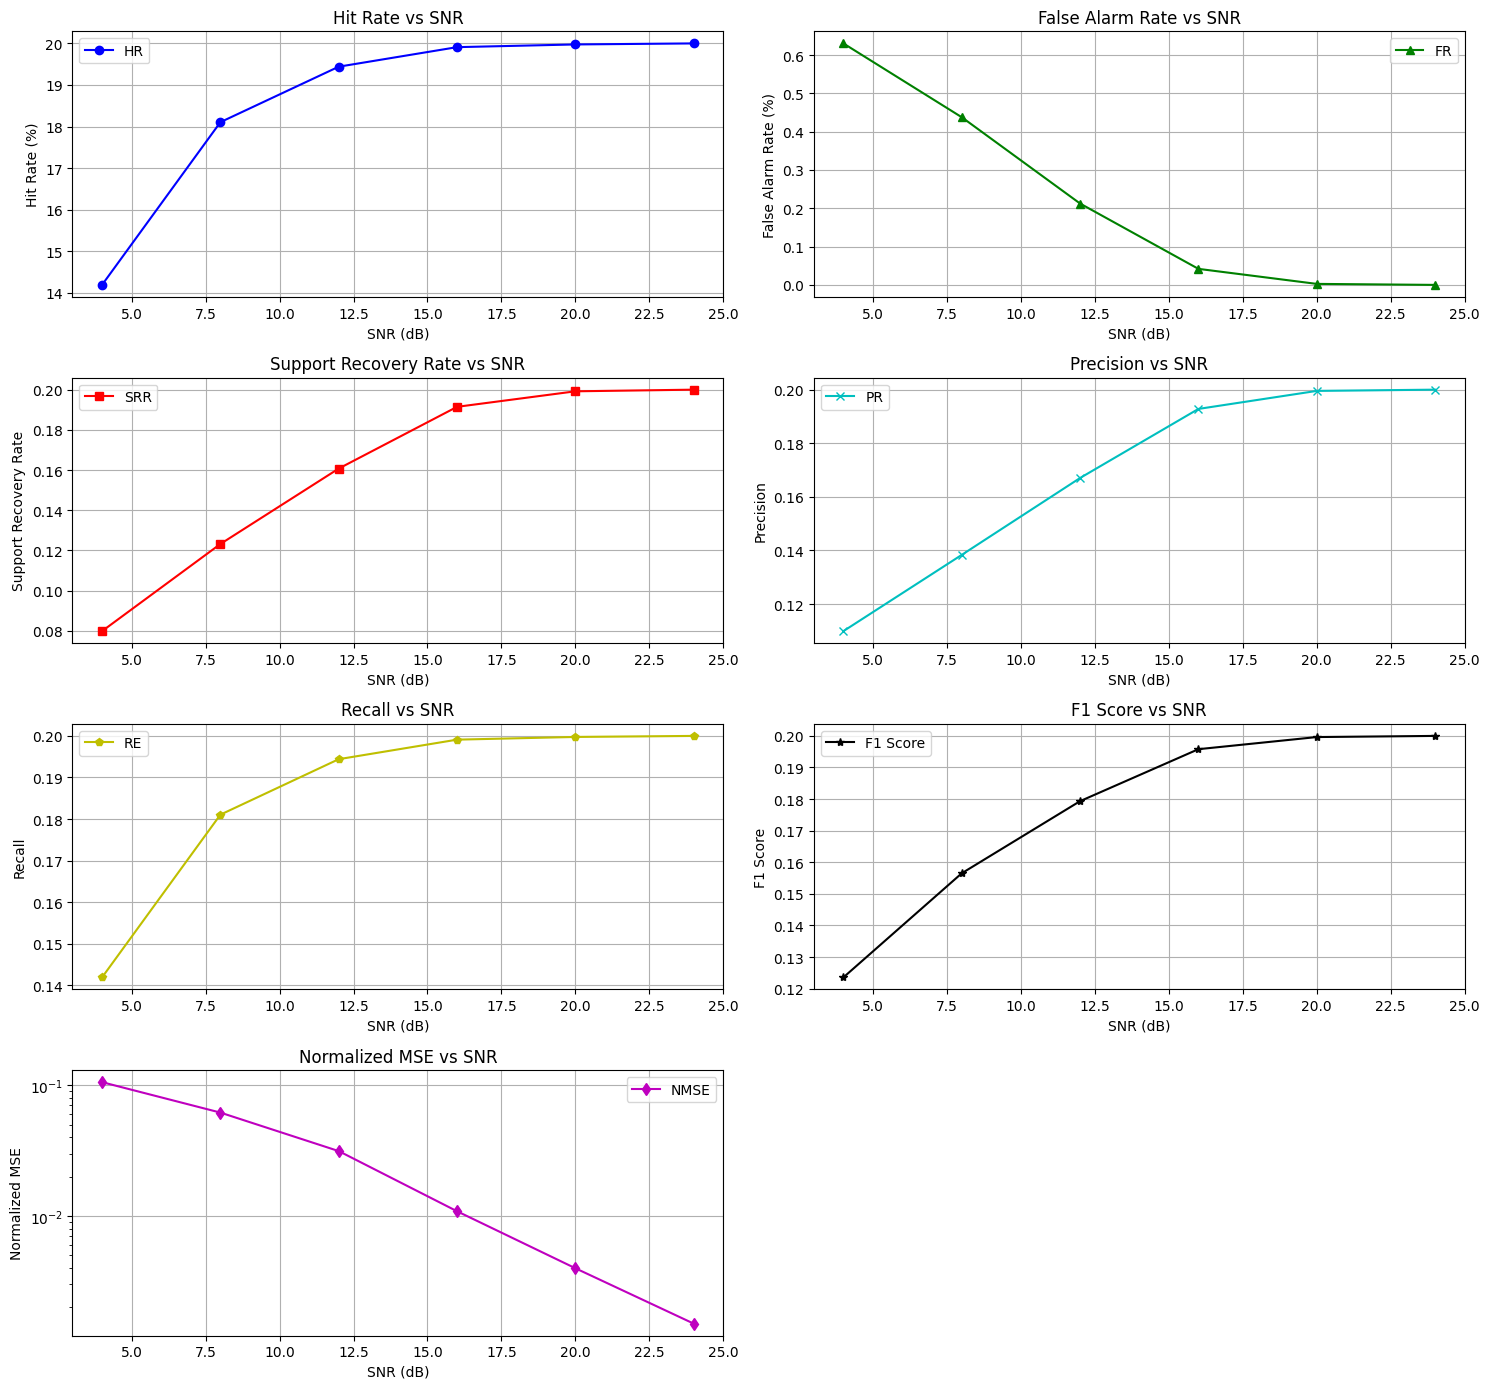

In [9]:
import matplotlib.pyplot as plt

# Define the SNR values for x-axis
snr_values = snr_db_array

# Create subplots for different performance metrics
plt.figure(figsize=(15, 14))

# Plot Hit Rate (HR)
plt.subplot(4, 2, 1)
plt.plot(snr_values, avg_hr, marker='o', linestyle='-', color='b', label='HR')
plt.xlabel("SNR (dB)")
plt.ylabel("Hit Rate (%)")
plt.title("Hit Rate vs SNR")
plt.grid(True)
plt.legend()

# Plot False Alarm Rate (FR)
plt.subplot(4, 2, 2)
plt.plot(snr_values, avg_fr, marker='^', linestyle='-', color='g', label='FR')
plt.xlabel("SNR (dB)")
plt.ylabel("False Alarm Rate (%)")
plt.title("False Alarm Rate vs SNR")
plt.grid(True)
plt.legend()

# Plot Support Recovery Rate (SRR)
plt.subplot(4, 2, 3)
plt.plot(snr_values, avg_srr, marker='s', linestyle='-', color='r', label='SRR')
plt.xlabel("SNR (dB)")
plt.ylabel("Support Recovery Rate")
plt.title("Support Recovery Rate vs SNR")
plt.grid(True)
plt.legend()

# Plot Precision (PR)
plt.subplot(4, 2, 4)
plt.plot(snr_values, avg_pr, marker='x', linestyle='-', color='c', label='PR')
plt.xlabel("SNR (dB)")
plt.ylabel("Precision")
plt.title("Precision vs SNR")
plt.grid(True)
plt.legend()

# Plot Recall (RE)
plt.subplot(4, 2, 5)
plt.plot(snr_values, avg_re, marker='p', linestyle='-', color='y', label='RE')
plt.xlabel("SNR (dB)")
plt.ylabel("Recall")
plt.title("Recall vs SNR")
plt.grid(True)
plt.legend()

# Plot F1 Score (F1)
plt.subplot(4, 2, 6)
plt.plot(snr_values, avg_f1, marker='*', linestyle='-', color='k', label='F1 Score')
plt.xlabel("SNR (dB)")
plt.ylabel("F1 Score")
plt.title("F1 Score vs SNR")
plt.grid(True)
plt.legend()

# Plot Normalized MSE (NMSE)
plt.subplot(4, 2, 7)
plt.plot(snr_values, avg_nmse, marker='d', linestyle='-', color='m', label='NMSE')
plt.xlabel("SNR (dB)")
plt.ylabel("Normalized MSE")
plt.title("Normalized MSE vs SNR")
plt.yscale('log')  # Log scale for better visualization
plt.grid(True)
plt.legend()

# Adjust layout and show the plots
plt.tight_layout()
plt.show()


In [10]:
import matplotlib.pyplot as plt
import numpy as np

def plot_res_vs_ground_truth(sbl_results, Z, sample_index, snr_index, snr_value):
    """Plot sbl reconstructed signal vs ground truth (Z) for a single sample at a given SNR."""
    plt.figure(figsize=(10, 5))

    # Ground truth (Z)
    plt.plot(np.abs(Z[sample_index,:,0]), marker='s', linestyle='--', color='g', label="Ground Truth (Z)")

    # sbl Estimated Signal
    plt.plot(np.abs(sbl_results[sample_index, snr_index, :, 0]), marker='o', linestyle='-', color='b', label="sbl Estimate")

    plt.xlabel("Device Index")
    plt.ylabel("Magnitude of Signal")
    plt.title(f"sbl vs. Ground Truth (Sample {sample_index}, SNR {snr_value} dB)")
    plt.legend()
    plt.grid(True)
    plt.show()

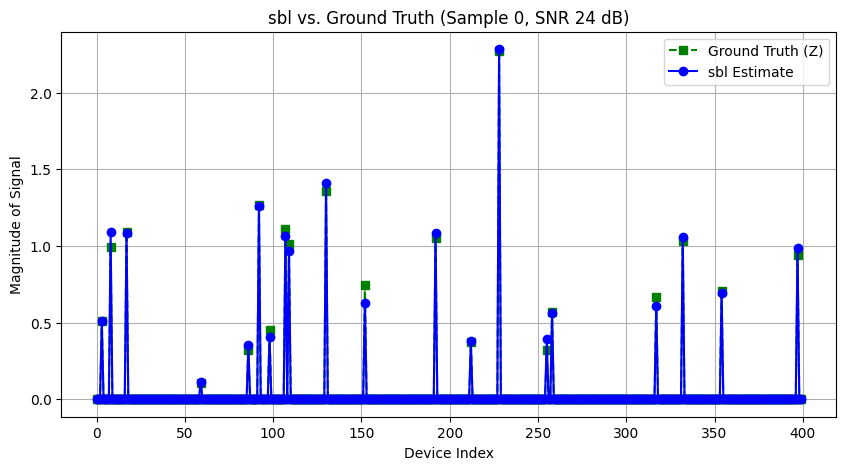

In [11]:
sample_index = 0  # Choose a specific sample
snr_index = 5  # Choose a specific SNR index
snr_value = snr_db_array[snr_index]

plot_res_vs_ground_truth(z_res, all_z, sample_index, snr_index, snr_value)

In [12]:
import matplotlib.pyplot as plt
import numpy as np

def plot_gamma_res_vs_ground_truth(gamma_res, gamma_true, sample_index, snr_index, snr_value):
    """Plot sbl estimated gamma vs ground truth gamma for a single sample at a given SNR."""
    plt.figure(figsize=(10, 5))

    device_indices = np.arange(len(gamma_true[sample_index]))  # X-axis: Device indices

    # Plot ground truth gamma (binary)
    plt.stem(device_indices, gamma_true[sample_index], linefmt='g--', markerfmt='gs', basefmt=" ", label="Ground Truth (γ)")

    # Plot sbl estimated gamma
    plt.stem(device_indices, gamma_res[sample_index, snr_index], linefmt='b-', markerfmt='bo', basefmt=" ", label="sbl Estimate (γ)")

    plt.xlabel("Device Index")
    plt.ylabel("Activity Indicator (0=Inactive, 1=Active)")
    plt.title(f"Device Activity (sbl vs. Ground Truth) - Sample {sample_index}, SNR {snr_value} dB")
    plt.legend()
    plt.grid(True)
    plt.show()


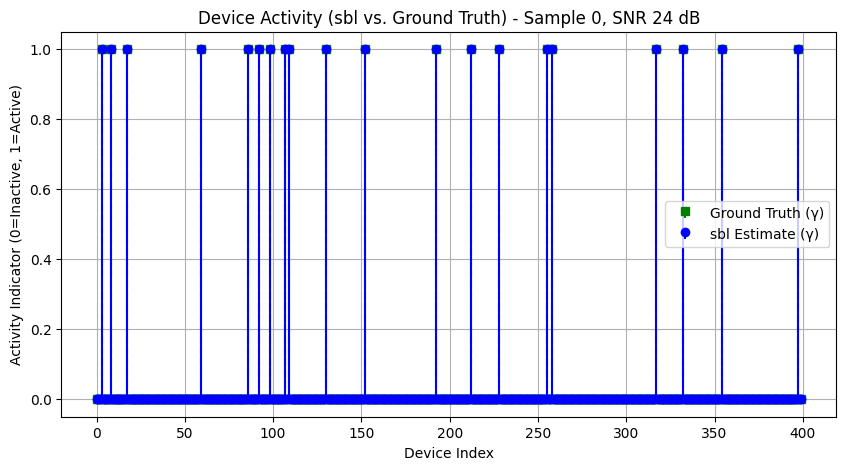

In [13]:
sample_index = 0  # Choose a specific sample
snr_index = 5  # Choose a specific SNR index
snr_value = snr_db_array[snr_index]

plot_gamma_res_vs_ground_truth(gamma_res, all_gamma, sample_index, snr_index, snr_value)